In [4]:
import gplately
import numpy as np
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.gridliner as grd
import matplotlib as mpl
from cmcrameri import cm
import pygplates


In [7]:
# Directory to plate model files

input_directory = f'./pmag_test_data/Merdith_2021'

# Locate rotation files and set up the RotationModel object
rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model_MER21 = pygplates.RotationModel(rotation_filenames)

# Locate topology feature files and set up a FeatureCollection object 
topology_filenames = glob.glob(os.path.join(input_directory, '*Merdith_et_al.gpml'))
#poly_filenames
topology_features_MER21 = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    # (omit files with the string "inactive" in the filepath)
    if "Inactive" not in topology_filename:
        topology_features_MER21.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)

# Locate static polygons and set up another FeatureCollection object
static_polygon_file = f'{input_directory}/shapes_continents.gpml'
static_polygons_MER21 = pygplates.FeatureCollection(static_polygon_file)

# Find other polygon files to plot
continents_MER21 = f'{input_directory}/shapes_continents.gpml'

model_MER21 = gplately.PlateReconstruction(rotation_model_MER21, topology_features_MER21, static_polygons_MER21)


/Users/andrew/Documents/GitHub/gplately/gplately/pygplates.py:199: ImportWarning: 
RotationModel: No filename associated with <class 'pygplates.pygplates.RotationModel'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates
  _warnings.warn(msg, ImportWarning)


In [9]:
# I dont know why, but on my laptop i have to interupt then rerun this cell
# otherwise it lags
pmag_file = f'./pmag_test_data/Torsvik_2012.gpml' # poles from Torsvik et al. 2012
pmag = pygplates.FeatureCollection(pmag_file)


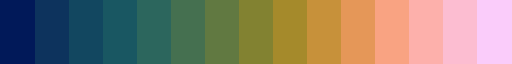

In [10]:
#make color map for plots
cmap = cm.batlow
colors = cmap(np.linspace(0, 1, 15))

cmaps = mpl.colors.ListedColormap(colors)
cmaps

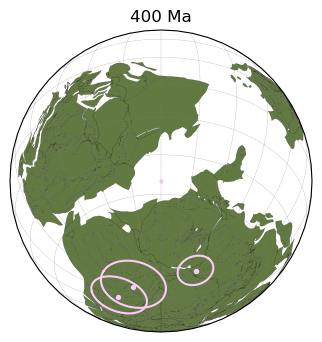

In [14]:
# Call the PlotTopologies object
time = 400 #Ma
gplot_MER21 = gplately.PlotTopologies(model_MER21, continents=continents_MER21,
                                      time=time)

# Set up a GeoAxis plot
fig = plt.figure(figsize=(4,4), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=-30, 
                                                       central_latitude=-40))
ax.gridlines(color='0.5',linestyle='--', linewidth=0.2,
             xlocs=np.arange(-180,180,15), 
             ylocs=np.arange(-90,90,15))   
plt.title(f'{time} Ma')

# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot_MER21.time = time # Ma
gplot_MER21.plot_continents(ax, facecolor=colors[6], edgecolor='k', lw=0.1)
ax.set_global()

recon_poles = []
pygplates.reconstruct(pmag, rotation_model_MER21, recon_poles, time)
pole_name = []
for i, pole in enumerate(recon_poles):
    gplately.plot.plot_pole(
        ax,
        pole.get_reconstructed_geometry().to_lat_lon()[1],
        pole.get_reconstructed_geometry().to_lat_lon()[0],
        pole.get_feature().get(pygplates.PropertyName.gpml_pole_a95).get_value().get_double(),
        color=colors[14], edgecolor=None, markersize=8)
    
    # now plot sample location
    sample_lat = pole.get_feature().get(pygplates.PropertyName.gpml_average_sample_site_position).get_value().get_point().to_lat_lon()[0]
    sample_lon = pole.get_feature().get(pygplates.PropertyName.gpml_average_sample_site_position).get_value().get_point().to_lat_lon()[1]
    ax.scatter(sample_lon, sample_lat, color=colors[14], s=3)
    
#fig.savefig('./figs/Fig1b.pdf')